# Intro
In this notebook I'll apply different EDA (Exploratory Data Analysis) techniques on the Heart Failure Prediction data.

The goal is to predict if a patient will have a Heart Failure or not the using LightGBM Classifier to predict based on given medical features.

## Attribute Information
| Variable          | Definition                                                             | Key                                             |
|-------------------|------------------------------------------------------------------------|-------------------------------------------------|
| Age               | age of the patient                                                     | years                                           |
| Sex               | sex of the patient                                                     | M = Male, F = Female                            |
| ChestPainType     | chest pain type                                                        | TA = Typical Angina, ATA = Atypical Angina, NAP = Non-Anginal Pain, ASY = Asymptomatic                                                                                                               |  
| RestingBP         | resting blood pressure                                                 | mm Hg                                           |
| Cholesterol       | serum cholesterol                                                      | mm/dl                                           | 
| FastingBS         | fasting blood sugar                                                    | 1 = if FastingBS > 120 mg/dl, 0 = otherwise     |
| RestingECG        | resting electrocardiogram results                                       | Normal = Normal, ST = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH = showing probable or definite left ventricular hypertrophy by Estes' criteria |
| MaxHR             | maximum heart rate achieved                                            | Numeric value between 60 and 202                |
| ExerciseAngina    | exercise-induced angina                                                | Y = Yes, N = No                                 |
| Oldpeak           | oldpeak = ST                                                           | Numeric value measured in depression            |
| ST_Slope          | the slope of the peak exercise ST segment                              | Up = upsloping, Flat = flat, Down = downsloping |
| HeartDisease      | output class                                                           | 1 = heart disease, 0 = Normal                   |

# Import Libaries

In [1]:
import sys
import math
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# import plotly
import plotly.express as px
import plotly.offline
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import ipywidgets as widgets
from ipywidgets import interact

sns.set_style('whitegrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
print(f'Python  version: {sys.version}')
print(f'pandas  version: {pd.__version__}')
print(f'numpy   version: {np.__version__}')
print(f'seaborn version: {sns.__version__}')

pd.Timestamp.now()
# pd.Timestamp.now().strftime('%Y-%m-%d')

Python  version: 3.8.2 (default, Mar 26 2020, 10:43:30) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
pandas  version: 1.3.3
numpy   version: 1.21.2
seaborn version: 0.11.2


Timestamp('2021-11-05 12:31:41.936165')

# Load data

In [4]:
url = 'https://raw.githubusercontent.com/GuySuphakit/Heart-Failure-Prediction/main/heart.csv'
temp_df = pd.read_csv(url)
temp_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


# Getting to know the data

In this section, we'll take a quick look at the data, to see how many row are there, and whther there are any missing values or not, to decie what kind of preprocessing will be needed.

In [5]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


The dataset consists of 918 samples and 12 columns : 8 predictors and one target variable and there are no missing values (which is a very good thing!) but looking at the dtypes. It seems that all discrete columns are in object and continuous in int64.

# Data cleaning

As stated in the previous section, only few cleaning will be perform, mainly:
- Convert discrete columns to category
- If there is any duplicate data, drop it.

In [6]:
def read_data():
    url = 'https://raw.githubusercontent.com/GuySuphakit/Heart-Failure-Prediction/main/heart.csv'
    df = pd.read_csv(url)
    return df

def change_lebel_of_HeartDisease(df):
    # change the lebel of HeartDisease because it has caused some ambiguity.
    df.HeartDisease = df.HeartDisease.replace({0: 'Normal', 1: 'Heart Disease'})
    return df

def convert_obj_columns_to_category(df):
    for c in df.columns:
        col_type = df[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            df[c] = df[c].astype('category')
    return df

def drop_duplicate(df):
    df = df.drop_duplicates()
    return df

In [7]:
df = (read_data()
      .pipe(change_lebel_of_HeartDisease)
      .pipe(convert_obj_columns_to_category)
      .pipe(drop_duplicate))
      
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,Normal
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,Heart Disease
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,Normal
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,Heart Disease
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,Normal


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Age             918 non-null    int64   
 1   Sex             918 non-null    category
 2   ChestPainType   918 non-null    category
 3   RestingBP       918 non-null    int64   
 4   Cholesterol     918 non-null    int64   
 5   FastingBS       918 non-null    int64   
 6   RestingECG      918 non-null    category
 7   MaxHR           918 non-null    int64   
 8   ExerciseAngina  918 non-null    category
 9   Oldpeak         918 non-null    float64 
 10  ST_Slope        918 non-null    category
 11  HeartDisease    918 non-null    category
dtypes: category(6), float64(1), int64(5)
memory usage: 56.4 KB


In [9]:
def print_category_columns(df):
    for c in df.columns:
        col_type = df[c].dtype
        if col_type.name == 'category':
            print(f'{c:15}: {list(enumerate(df[c].cat.categories))}')
            print('-' * 60)

print_category_columns(df)

Sex            : [(0, 'F'), (1, 'M')]
------------------------------------------------------------
ChestPainType  : [(0, 'ASY'), (1, 'ATA'), (2, 'NAP'), (3, 'TA')]
------------------------------------------------------------
RestingECG     : [(0, 'LVH'), (1, 'Normal'), (2, 'ST')]
------------------------------------------------------------
ExerciseAngina : [(0, 'N'), (1, 'Y')]
------------------------------------------------------------
ST_Slope       : [(0, 'Down'), (1, 'Flat'), (2, 'Up')]
------------------------------------------------------------
HeartDisease   : [(0, 'Heart Disease'), (1, 'Normal')]
------------------------------------------------------------


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Age             918 non-null    int64   
 1   Sex             918 non-null    category
 2   ChestPainType   918 non-null    category
 3   RestingBP       918 non-null    int64   
 4   Cholesterol     918 non-null    int64   
 5   FastingBS       918 non-null    int64   
 6   RestingECG      918 non-null    category
 7   MaxHR           918 non-null    int64   
 8   ExerciseAngina  918 non-null    category
 9   Oldpeak         918 non-null    float64 
 10  ST_Slope        918 non-null    category
 11  HeartDisease    918 non-null    category
dtypes: category(6), float64(1), int64(5)
memory usage: 56.4 KB


We cleaned the data with a clean code!

# Exploratory Data Analysis (EDA)
In this section, we'll explore the data visually and summarize it using descriptive statistic methods.

To keep things simpler, we'll divide this section into three subsections:

1. Univariate analysis: in this section we'll focus only at one variable at a time, and study the variable descriptive statistics with some charts like: Bar chart, Line chart, Histogram, Boxplot, etc ..., and how the variable is distributed, and if there is any skewness in the distribution.
2. Bivariate analysis: in this section we'll study the relation between two variables, and present different statistics such as Correlation, Covariance, and will use some other charts like: scatterplot, and will make use of the hue parameter of the previous charts.
3. Multivariate analysis: in this section we'll study the relation between three or more variables, and will use additional type of charts, such as parplot.

## Overall
Let's briefly see overall image of our dataset :

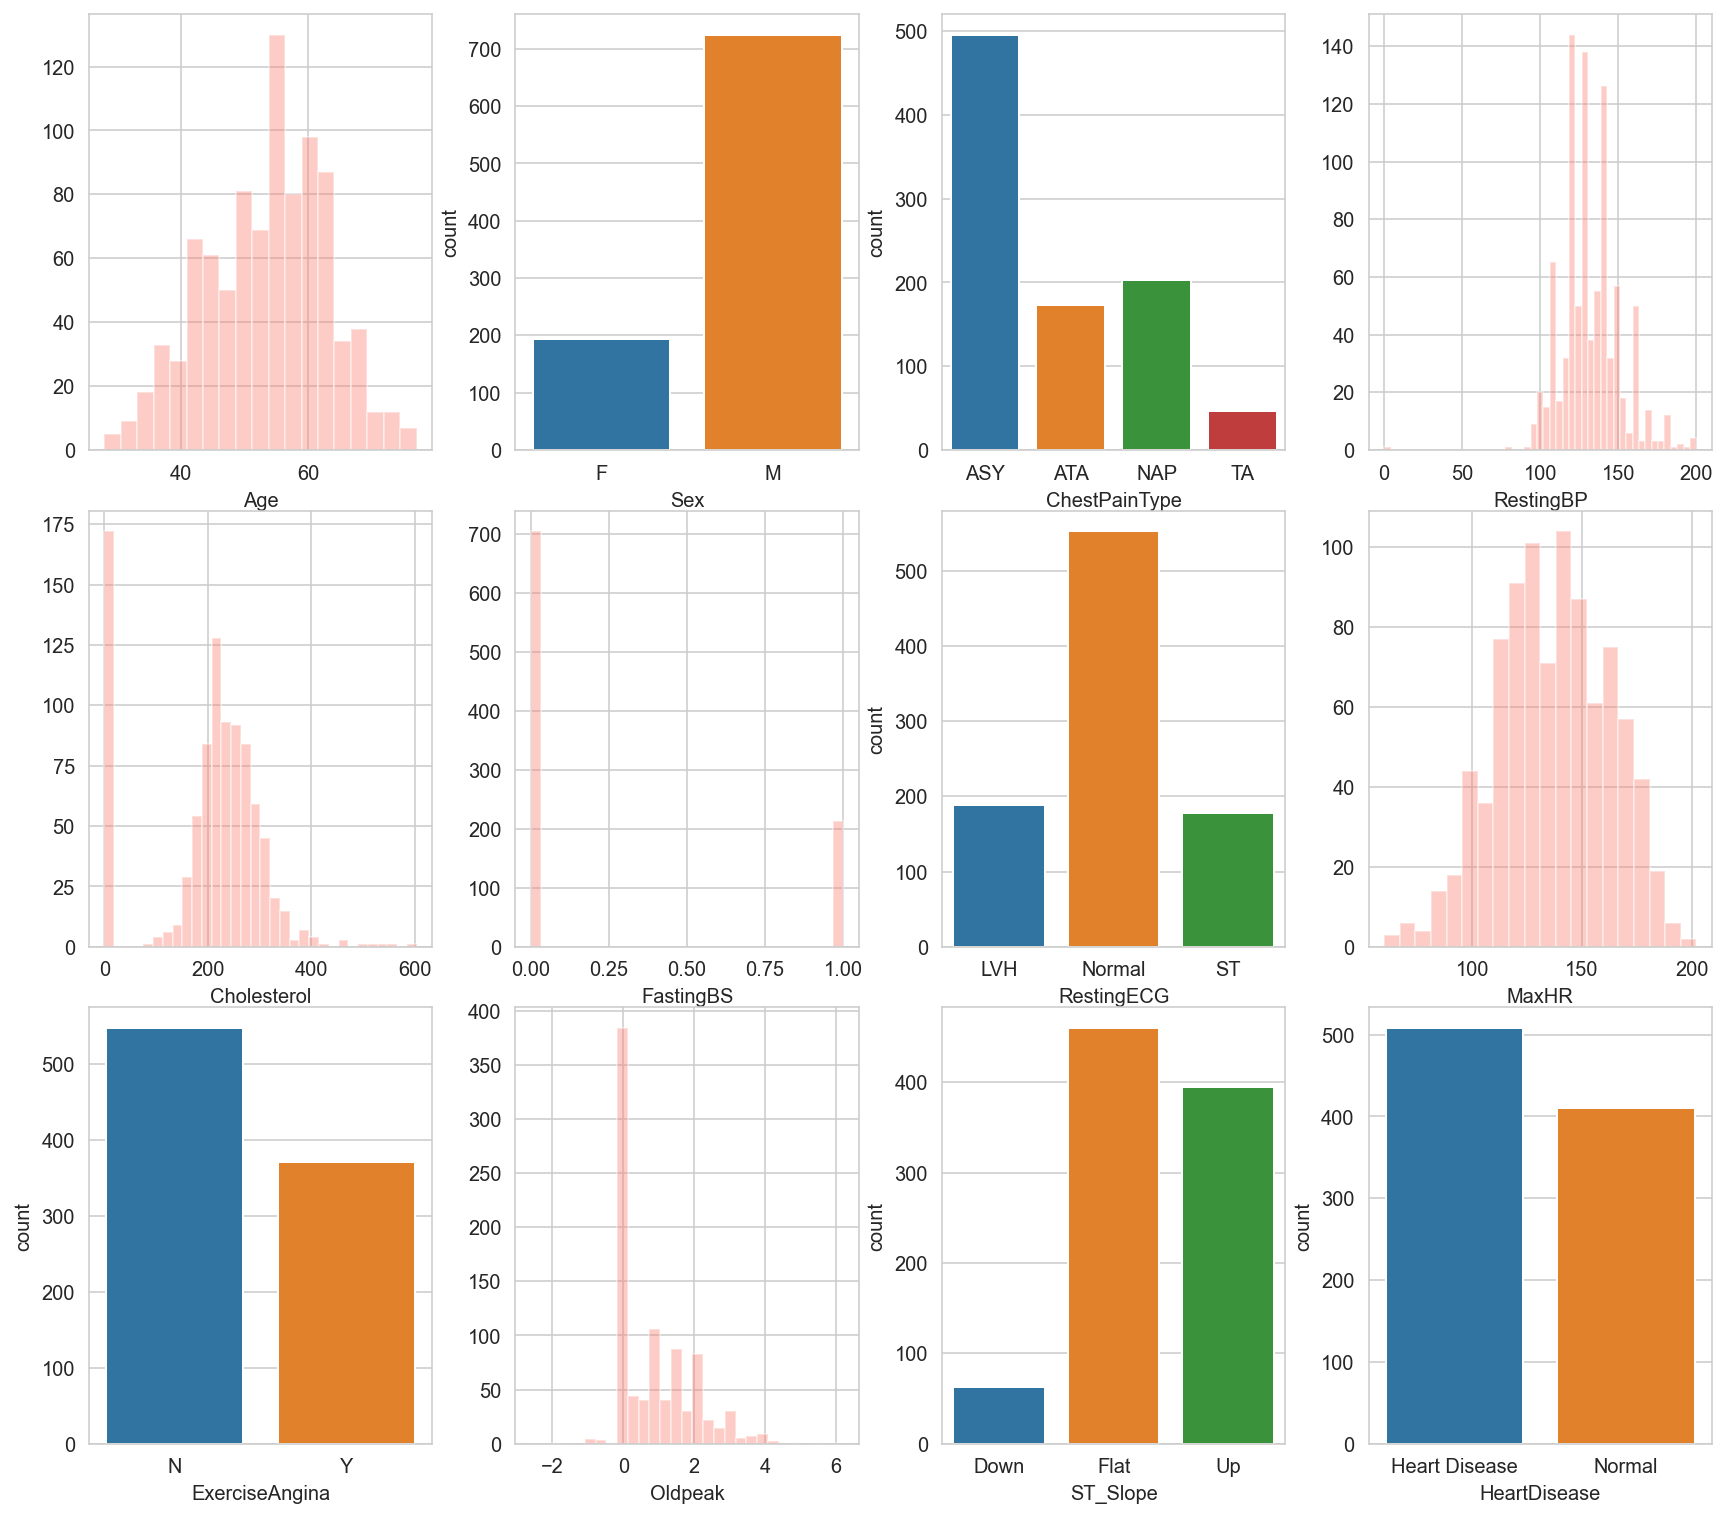

In [11]:
def plot_mn(df, cols, n_rows:int=1, kind:str='boxplot', color='salmon'):
    """
    plot boxplot, violin, hist in m (rows) by n (columns)
    >>> plot_mn(df, ['Calories', 'Fat'], 2, 'hist')
    """
    n=len(cols)
    n_cols=math.ceil(n / n_rows)
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3.5))
    ax=ax.ravel()

    fig.tight_layout()
    for i, c in enumerate(cols):
        col_type = df[c].dtype
        if col_type.name == 'category':
            sns.countplot(data=df, x=c, ax=ax[i])
        else:
            if kind.lower()=='boxplot':
                sns.boxplot(data=df[[c]], ax=ax[i], color=color)   
            if kind.lower()=='boxen':
                sns.boxenplot(data=df[[c]], ax=ax[i], color=color)   
            elif kind.lower()=='violin':
                sns.violinplot(data=df[[c]], ax=ax[i], color=color)   
            elif kind.lower()=='hist':
                sns.distplot(df[c], hist=True, kde=False, ax=ax[i], color=color)  

plot_mn(df, df.columns, 3, 'hist')

In [12]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [ ]:
df.describe().T.round(1)

In [ ]:
df.describe(include='category').T

In [ ]:
numerical= df.select_dtypes('int64').columns

categorical = df.select_dtypes('category').columns

print(f'Numerical Columns:  {df[numerical].columns}')
print('-'* 100)
print(f'Categorical Columns: {df[categorical].columns}')

In [ ]:
df.nunique()

## Univariate Analysis


Here in this section, will perform analysis on each variable individually, but according to the variable type different methods and visualization will be used, main types of variables:
- Numerical
    - Continuous: continuous variables are continous measurements.
    - Discrete: discrete variables represent counts.
- Categorical
    - Nominal: nominal variable has a finite set of possible values, which don't have any ordereing relation among them.
    - Ordinal: in contrast to Nominal variable, ordinal varible defines an ordering relation between the values.
    - Binary: binary variables are a special case of nominal variables, but they only have two possible values.

Types of varibles
- Continuous: Age, RestingBP, Cholesterol, Oldpeak and MaxHR  are continuous variables.
- Norminal: ChestPainType and RestingECG is nominal variables.
- Binary: Sex , ExerciseAngina, FastingBS and ST_Slope are a binary variable.

### Age
The Age is a Continuous variable.

In [ ]:
df["Age"].describe().round(1)

In [ ]:
df.Age.mode()[0]

In [ ]:
print(stats.skew(df.Age))

In [ ]:
fig = px.histogram(df, x='Age', marginal='box')
fig.update_traces(marker_line_width=1, marker_line_color="black")
fig.show()

We can conclude from this chats following:
- The Age is very close to a normal distribution, with a smll negative skewness (left skewed)
- The most common scores are between 47 and 60
- The average age is 53.5 with a standard deviation of 9.4
- There are no outliers

### Sex
The Sex variable indicates whether the patient' sex is male or female, so it's a binary variable.

In [ ]:
df.Sex.value_counts()

In [ ]:
temp_df = df.groupby(by="Sex", as_index=False).agg(
    counts=pd.NamedAgg(column="Sex", aggfunc="count")).sort_values(by="counts", ascending=False)

fig = px.bar(temp_df, 
            x='Sex', 
            y='counts',
            color='Sex',
            color_continuous_scale=px.colors.qualitative.D3)

fig.update_traces(marker_line_width=1, marker_line_color="black")
fig.show()

### ChestPainType
The ChestPainType is nominal variables.

In [ ]:
df.ChestPainType.value_counts()

In [ ]:
temp_df = df.groupby(by="ChestPainType", as_index=False).agg(
    counts=pd.NamedAgg(column="ChestPainType", aggfunc="count")).sort_values(by="counts", ascending=False)

fig = px.bar(temp_df,
            x='ChestPainType',
            y='counts',
            color='counts',
            color_discrete_sequence = px.colors.qualitative.D3)
fig.update_traces(marker_line_width=1, marker_line_color="black")
fig.show()

Most of ChestPainType is ASY.
- TA = Typical Angina 
- ATA = Atypical Angina
- NAP = Non-Anginal Pain
- ASY = Asymptomatic

### RestingBP
The RestingBP(resting blood pressure) is continous variable.

In [ ]:
df.RestingBP.describe().round()

In [ ]:
df.RestingBP.mode()[0]

In [ ]:
print(stats.skew(df.RestingBP))

In [ ]:
fig = px.histogram(df, x='RestingBP', marginal='box')
fig.update_traces(marker_line_width=1, marker_line_color="black")
fig.show()

In [ ]:
df[df['RestingBP'] == 0]

The plot shows that:
- most patient have resting blood pressure between 120 and 140
- The distribution is moderately skewd to the right with a positive skew value 0.18
- There is 1 record with RestingBP = 0, which is not normal.

### Cholesterol
The Cholesterol is continuous varible.

In [ ]:
df.Cholesterol.describe().round()

In [ ]:
df.Cholesterol.mode()[0]

In [ ]:
print(stats.skew(df.Cholesterol))

In [ ]:
fig = px.histogram(df, x='Cholesterol', marginal='box')
fig.update_traces(marker_line_width=1, marker_line_color="black")
fig.show()

In [ ]:
df[df['Cholesterol'] == 0].head()

In [ ]:
df[df['Cholesterol'] >= 500]['Cholesterol']

There are many patients who are not supposed to have Choresterol = 0, which is impossible and the outliers are above value 458 since such high Cholesterol is only seen in a small number of people. We require more processing to analyse data statistics.

### FastingBS
The FastingBS(fasting blood sugar) is binary variable since 	1 = if FastingBS > 120 mg/dl, 0 = otherwise.

In [ ]:
df.FastingBS.value_counts()

In [ ]:
fig = px.histogram(df, x='FastingBS', color='FastingBS')
fig.update_traces(marker_line_width=1, marker_line_color="black")
fig.show()

### RestingECG
RestingECG stands for resting electrocardiogram results and it have Normal, ST and LVH. so, this is an norminal variable.



In [ ]:
df["RestingECG"].value_counts()

In [ ]:
temp_df = df.groupby(by="RestingECG", as_index=False).agg(
    counts=pd.NamedAgg(column="RestingECG", aggfunc="count")).sort_values(by="counts", ascending=False)

In [ ]:
fig = px.bar(temp_df,
            x='RestingECG',
            y='counts',
            color='counts',
            color_discrete_sequence = px.colors.qualitative.D3)
fig.update_traces(marker_line_width=1, marker_line_color="black")
fig.show()

### MaxHR
It's Continuos variable.

In [ ]:
df.MaxHR.describe().round()

In [ ]:
df.MaxHR.mode()[0]

In [ ]:
df.MaxHR.skew()

In [ ]:
fig = px.histogram(df, x='MaxHR', marginal='box')
fig.update_traces(marker_line_width=1, marker_line_color="black")
fig.show()

This variable looking like a normal distribution, with a small negative skewness.

### ExerciseAngina
It's binary variable.

In [ ]:
df.ExerciseAngina.value_counts()

In [ ]:
temp_df = df.groupby(by="ExerciseAngina", as_index=False).agg(
    counts=pd.NamedAgg(column="ExerciseAngina", aggfunc="count")).sort_values(by="counts", ascending=False)

fig = px.bar(temp_df, 
            x='ExerciseAngina', 
            y='counts',
            color='ExerciseAngina',
            color_continuous_scale=px.colors.qualitative.D3)

fig.update_traces(marker_line_width=1, marker_line_color="black")
fig.show()

### Oldpeak
It's Continuos variable.

In [ ]:
df.Oldpeak.describe().round()

In [ ]:
df.Oldpeak.mode()[0]

In [ ]:
df.Oldpeak.skew()

In [ ]:
fig = px.histogram(df, x='Oldpeak', marginal='box')
fig.update_traces(marker_line_width=1, marker_line_color="black")
fig.show()

### ST_Slope
It's binary variable.

In [ ]:
df.ST_Slope.value_counts()

In [ ]:
temp_df = df.groupby(by="ST_Slope", as_index=False).agg(
    counts=pd.NamedAgg(column="ST_Slope", aggfunc="count")).sort_values(by="counts", ascending=False)

fig = px.bar(temp_df, 
            x='ST_Slope', 
            y='counts',
            color='ST_Slope',
            color_continuous_scale=px.colors.qualitative.D3)

fig.update_traces(marker_line_width=1, marker_line_color="black")
fig.show()

### HeartDisease
It's binary variable.

In [ ]:
df.HeartDisease.value_counts()

In [ ]:
fig = px.histogram(df, x='HeartDisease', color='HeartDisease')
fig.update_traces(marker_line_width=1, marker_line_color="black")
fig.show()

## Bivariate analysis

In this section, we'll focus on studying the relationship between two different variables, to answer different question, like

- What is the relation between variable x and variable y? is it linear or non-linear?
- In case of a linear relation, is positive linear relation or negative linear relation? and how strong is the relation?
- How the distribution for two variables changes?

### Correlation Matrix

In [ ]:
dcorr=df[df.columns].corr()
# dcorr

mask = np.zeros_like(dcorr)
# mask.shape
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(10,8)) 
sns.heatmap(dcorr, cmap=sns.diverging_palette(10, 145, n=100), 
            vmin=-1, vmax=1, center=0, linewidths=1, annot=True, mask=mask, ax=ax).set_title("Correlation\nHeatmap", fontsize=22,fontweight="bold");

### Scatter plot
Let's show the scatter for each two variables at a time:

In [ ]:
corr_value = df["Age"].corr(df["RestingBP"])

fig = px.scatter(
    data_frame=df,
    x="Age",
    y="RestingBP",
    marginal_x="histogram",
    marginal_y="histogram",
    trendline="ols",
    trendline_color_override="red",
    title=f"Correlation between Age and RestingBP is: {corr_value:.2f}",
)

fig.show()

In [ ]:
corr_value = df["Age"].corr(df["Cholesterol"])

fig = px.scatter(
    data_frame=df,
    x="Age",
    y="Cholesterol",
    marginal_x="histogram",
    marginal_y="histogram",
    trendline="ols",
    trendline_color_override="red",
    title=f"Correlation between Age and Cholester0l is: {corr_value:.2f}",
)

fig.show()

In [ ]:
corr_value = df["Age"].corr(df["Oldpeak"])

fig = px.scatter(
    data_frame=df,
    x="Age",
    y="Oldpeak",
    marginal_x="histogram",
    marginal_y="histogram",
    trendline="ols",
    trendline_color_override="red",
    title=f"Correlation between Age and Oldpeak is: {corr_value:.2f}",
)

fig.show()

In [ ]:
corr_value = df["Age"].corr(df["MaxHR"])

fig = px.scatter(
    data_frame=df,
    x="Age",
    y="MaxHR",
    marginal_x="histogram",
    marginal_y="histogram",
    trendline="ols",
    trendline_color_override="red",
    title=f"Correlation between Age and MaxHR is: {corr_value:.2f}",
)

fig.show()

### Bivariate distributions
Another way to study the relation between two variables is with 2D Histograms (distribution).

Just like the distributions we used in the Univariate Analysis section, we can show the distribution for two variables x and y, which would give us better insights on how much the values from the two variables overlap, and show cluster regions in the 2D space.

Compared to scatter plots, 2D histograms are better at handling large amounts of data, as they use rectangular bins, and count the number of points withing each bin.

In [ ]:
fig = px.density_heatmap(
    data_frame=df, x="Age", y="RestingBP", color_continuous_scale="PuBu"
)

fig.show()

We can see from this chart some clusters.

For example, there are two clusters of Patient who age between 50 and 54 years old and the other clusters of Patient who age between 55 and 59 years old. These two clusters account for about 100 patients. (which is about 10% of the total dataset)

In [ ]:
fig = px.density_heatmap(
    data_frame=df, x="Age", y="Cholesterol", color_continuous_scale="PuBu"
)

fig.show()

This chart shows that patients who age above 50 has a higher Cholesterol level than patients who age below 50.

In [ ]:
fig = px.density_heatmap(
    data_frame=df, x="Age", y="MaxHR", color_continuous_scale="PuBu"
)

fig.show()

This chart shows that MaxHR ia lower when the patient is older. This is a positive linear relation.

In [ ]:
fig = px.density_heatmap(
    data_frame=df, x="Age", y="Oldpeak", color_continuous_scale="PuBu"
)

fig.show()

This chart shows that almost of the patients has 0.1 - 0.2 oldpeak.

## Multivariate analysis
So far, all the plots we used before were used either to explore one variable, or to show the relation between a pair of variables.

However, we are often interested in answering the question: How does the relation between two variables changes as a function of a third variable?

In this section, we'll focus on answering these kinds of questions, where we'll use similar plots to the ones we used before, with conditioning on other variable.

### Pairplot

In [ ]:
sns.pairplot(df, hue="HeartDisease", palette="husl", corner=True);

### Bivariate distribution with HeartDisease

#### Age vs RestingBP

In [ ]:
px.density_heatmap(
    data_frame=df,
    x="Age",
    y="RestingBP",
    color_continuous_scale="PuBu",
    facet_col="HeartDisease",
    title="Age vs. Chelesterol for different Heart Disease values",
)

#### Age vs Cholesterol

In [ ]:
px.density_heatmap(
    data_frame=df,
    x="Age",
    y="Cholesterol",
    color_continuous_scale="PuBu",
    facet_col="HeartDisease",
    title="Age vs. Chelesterol for different Heart Disease values",
)

#### Age vs MaxHR

In [ ]:
px.density_heatmap(
    data_frame=df,
    x="Age",
    y="MaxHR",
    color_continuous_scale="PuBu",
    facet_col="HeartDisease",
    title="Age vs. Chelesterol for different Heart Disease values",
)

In [ ]:
def num_plot(df, col):
    fig = px.histogram(df, x=col, color="HeartDisease",
                       marginal="box")
    fig.update_layout(height=400, width=700, showlegend=True)
    fig.update_traces(marker_line_width=1,marker_line_color="black")
    fig.show()
    
cols= df.columns
for col in cols:
    num_plot(df, col)

We can see some different between Normal and HeartDisease.

# Data Preprocessing

After we see all the chart and analysis, we'll start some preprocessing the data before move to the model section.

In [13]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, ShuffleSplit, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, precision_recall_fscore_support, f1_score

In [14]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [15]:
feature_cols = ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope']
target_cols = 'HeartDisease'

X = df[feature_cols]
y = df[target_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

In [16]:
y_train.value_counts()

Heart Disease    432
Normal           348
Name: HeartDisease, dtype: int64

In [17]:
def data_preprocessing(X_train):
    ''' replace outliers with mean to make the distribution more normal. '''    
    mean_chol = X_train[X_train.Cholesterol > 0]['Cholesterol'].mean()
    mean_rest = X_train[X_train.RestingBP > 0]['Cholesterol'].mean()
    
    X_train['Cholesterol'].replace(to_replace = [0,X_train[X_train['Cholesterol'] >= 500]['Cholesterol']], value = mean_chol, inplace = True)
    X_train['RestingBP'].replace(to_replace = [0,244.635389], value = mean_rest, inplace = True)

    return X_train

X_train = data_preprocessing(X_train)

# Model

In [18]:
import lightgbm as lgb
print(f'lightgbm version {lgb.__version__}')

lightgbm version 3.2.1


In [19]:
clf = lgb.LGBMClassifier()

In [20]:
clf.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [21]:
fit_params={'early_stopping_rounds':20, 
            'eval_metric': 'auc',
            'eval_set': [(X_test, y_test)],
            'verbose': 10
           }

clf.fit(X_train, y_train, **fit_params)

Training until validation scores don't improve for 20 rounds
[10]	valid_0's auc: 0.940683	valid_0's binary_logloss: 0.40307
[20]	valid_0's auc: 0.945671	valid_0's binary_logloss: 0.327165
[30]	valid_0's auc: 0.943973	valid_0's binary_logloss: 0.314048
[40]	valid_0's auc: 0.950552	valid_0's binary_logloss: 0.289311
[50]	valid_0's auc: 0.947156	valid_0's binary_logloss: 0.293082
[60]	valid_0's auc: 0.942275	valid_0's binary_logloss: 0.306539
Early stopping, best iteration is:
[40]	valid_0's auc: 0.950552	valid_0's binary_logloss: 0.289311


LGBMClassifier()

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

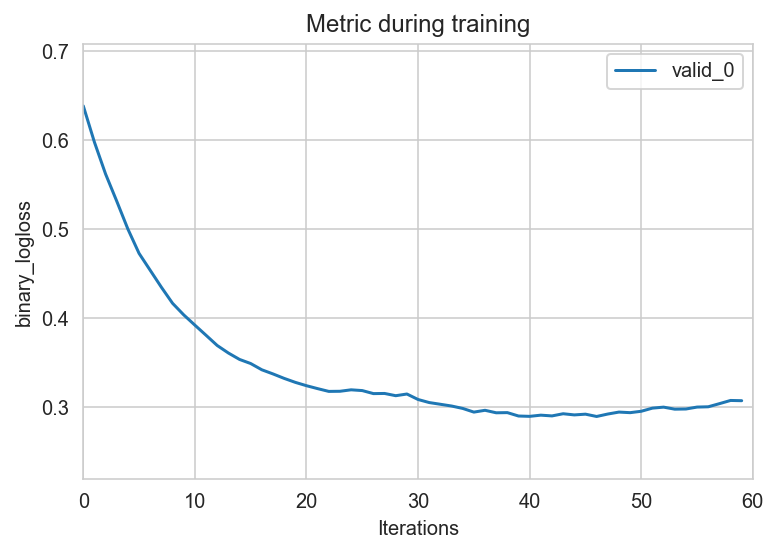

In [22]:
lgb.plot_metric(clf, metric='binary_logloss')

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='auc'>

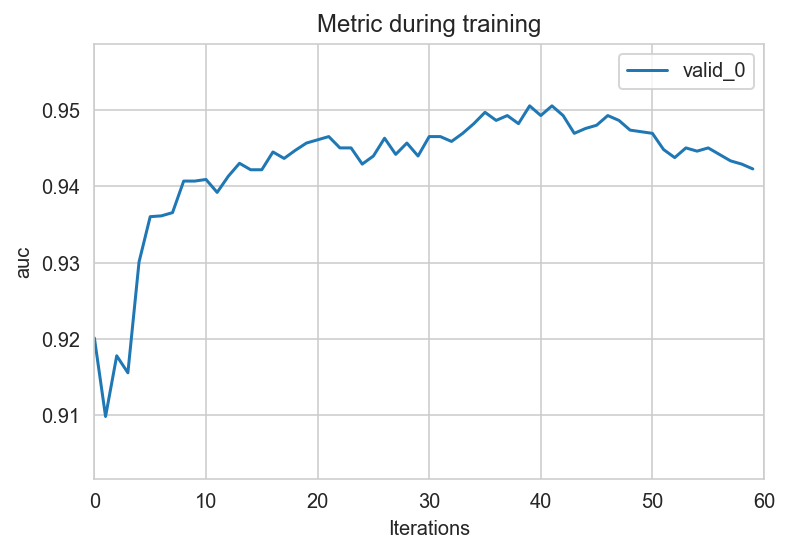

In [23]:
lgb.plot_metric(clf, metric='auc')

In [24]:
clf.score(X_train, y_train) # classification accuracy score

0.9602564102564103

In [25]:
clf.score(X_test, y_test) # classification accuracy score

0.8840579710144928

### confusion matrix
$$
\begin{bmatrix}
C_{0,0} & C_{0,1} \\
C_{1,0} & C_{1,1}
\end{bmatrix}
=
\begin{bmatrix}
tn&fp \\
fn&tp
\end{bmatrix}
$$

<table>
<tr>
    <td></td>
    <td>predicted false</td>
    <td>predicted true</td>
</tr>
<tr>
    <td>actual false</td>
    <td>tn</td>
    <td>fp</td>
</tr>
<tr>
    <td>actual true</td>
    <td>fn</td>
    <td>tp</td>
</tr>
<table>

In [26]:
cm = confusion_matrix(y_test, clf.predict(X_test))
cm

array([[69,  7],
       [ 9, 53]])

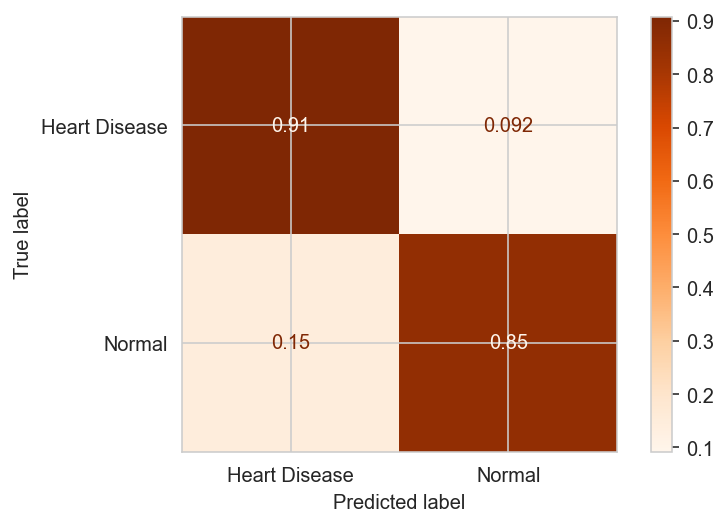

In [27]:
plot_confusion_matrix(clf, X_test, y_test, cmap='Oranges', normalize='true')

In [28]:
from flaml import AutoML
automl = AutoML()

In [29]:
settings = {
    "time_budget": 120,  # total running time in seconds
    "metric": 'accuracy',  # can be: 'r2', 'rmse', 'mae', 'mse', 'accuracy', 'roc_auc', 'roc_auc_ovr',
                           # 'roc_auc_ovo', 'log_loss', 'mape', 'f1', 'ap', 'ndcg', 'micro_f1', 'macro_f1'
    "task": 'classification',  # task type
    "log_file_name": 'airlines_experiment.log',  # flaml log file
}

In [30]:

automl.fit(X_train=X_train, y_train=y_train, **settings)

[flaml.automl: 11-05 12:34:14] {890} INFO - Evaluation method: cv
[flaml.automl: 11-05 12:34:14] {596} INFO - Using StratifiedKFold
[flaml.automl: 11-05 12:34:14] {911} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 11-05 12:34:14] {929} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'lrl1']
[flaml.automl: 11-05 12:34:14] {993} INFO - iteration 0, current learner lgbm
[flaml.automl: 11-05 12:34:14] {1141} INFO -  at 0.2s,	best lgbm's error=0.1872,	best lgbm's error=0.1872
[flaml.automl: 11-05 12:34:14] {993} INFO - iteration 1, current learner lgbm
[flaml.automl: 11-05 12:34:14] {1141} INFO -  at 0.3s,	best lgbm's error=0.1872,	best lgbm's error=0.1872
[flaml.automl: 11-05 12:34:14] {993} INFO - iteration 2, current learner lgbm
[flaml.automl: 11-05 12:34:15] {1141} INFO -  at 0.4s,	best lgbm's error=0.1564,	best lgbm's error=0.1564
[flaml.automl: 11-05 12:34:15] {993} INFO - iteration 3, current learner lgbm
[flaml.automl: 11-0

In [31]:
''' retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 12.0, 'num_leaves': 8.0, 'min_child_samples': 73.0, 'learning_rate': 0.40519458768866623, 'subsample': 0.9114565637952721, 'log_max_bin': 8.0, 'colsample_bytree': 0.7781686379822503, 'reg_alpha': 0.04756204061476492, 'reg_lambda': 0.23270963015251847}
Best accuracy on validation data: 0.8795
Training duration of best run: 0.1437 s


In [35]:
LGBMClassifier_automl = automl.model
LGBMClassifier_automl

LGBMClassifier(colsample_bytree=0.7781686379822503,
               learning_rate=0.40519458768866623, max_bin=255,
               min_child_samples=73, n_estimators=12, num_leaves=8,
               objective='binary', reg_alpha=0.04756204061476492,
               reg_lambda=0.23270963015251847, subsample=0.9114565637952721)

In [36]:
''' compute predictions of testing dataset ''' 
y_pred = LGBMClassifier_automl.predict(X_test)
print('Predicted labels', y_pred)
print('True labels', y_test)
y_pred_proba = LGBMClassifier_automl.predict_proba(X_test)[:,1]

Predicted labels [1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 1 1 0 0 1 1 0 0 1 0 1 1 0
 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 0 1 1 0 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 0 0 1 1 1]
True labels 343    Heart Disease
284           Normal
282           Normal
744    Heart Disease
585    Heart Disease
           ...      
672           Normal
619           Normal
491    Heart Disease
908    Heart Disease
917           Normal
Name: HeartDisease, Length: 138, dtype: category
Categories (2, object): ['Heart Disease', 'Normal']


In [ ]:
y_pred = 

In [37]:
''' compute different metric values on testing dataset'''
from flaml.ml import sklearn_metric_loss_score
print('accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred, y_test))
print('roc_auc', '=', 1 - sklearn_metric_loss_score('roc_auc', y_pred_proba, y_test))
print('log_loss', '=', sklearn_metric_loss_score('log_loss', y_pred_proba, y_test))

TypeError: Labels in y_true and y_pred should be of the same type. Got y_true=['Heart Disease' 'Normal'] and y_pred=[0 1]. Make sure that the predictions provided by the classifier coincides with the true labels.

## SHAP
> SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions.

[<img src="https://shap.readthedocs.io/en/latest/_images/shap_header.png" width=800>](https://shap.readthedocs.io/en/latest/)
* doc: https://shap.readthedocs.io/en/latest/
* installation:
    * `pip install shap` or
    * `conda install -c conda-forge shap`

In [ ]:
import shap
print(f'shap version {shap.__version__}')
# load JS visualization code to notebook
shap.initjs()

In [ ]:
def case_detail(case_data):
    '''
    format obj returned from shap.force_plot()
    '''
    de=pd.DataFrame(case_data.data['features'])
    fcols=[]
    for i in case_data.data['features'].keys():
        fcols.append(case_data.data['featureNames'][i])
    de.columns=fcols
    return de

def individual_case_plot(explainer, X, case_index, verbose=False):
    """
    >>> individual_case_plot(explainer, X_train, 1)
    """
    shap_values = explainer.shap_values(X.iloc[[case_index]])
    g=shap.force_plot(explainer.expected_value, shap_values=shap_values, features=X.iloc[case_index, :])
    if verbose:
        pprint(g.__dict__)
    return g

In [ ]:
# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(automl.model)
shap_values = explainer.shap_values(X_test)


In [ ]:
X

In [ ]:
shap_values[:3]

In [ ]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [ ]:
feature_cols

In [ ]:
dshap=pd.DataFrame(shap_values, columns=feature_cols)
dshap